Import stuff I need

In [1]:
import pyarrow.parquet as pq
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os


Upload into memory the data file. It is in parquet format.

In [2]:
table_sales = pq.read_table('../data/raw/modeldata.parquet')

table_sales includes data for homes in Cook County that have been sold in the past seven years. table includes data for all homes regardless of a sale. 

Convert to pandas dataframes.

In [3]:
df_bell_sales = table_sales.to_pandas()

examine columns

In [4]:
df_bell_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346293 entries, 0 to 346292
Data columns (total 98 columns):
 #   Column                        Non-Null Count   Dtype   
---  ------                        --------------   -----   
 0   meta_pin                      346293 non-null  object  
 1   meta_year                     346293 non-null  float64 
 2   meta_class                    346293 non-null  object  
 3   meta_town_code                346293 non-null  object  
 4   meta_nbhd                     346293 non-null  object  
 5   meta_2yr_pri_board_est_bldg   345640 non-null  float64 
 6   meta_2yr_pri_board_est_land   345640 non-null  float64 
 7   meta_1yr_pri_board_est_bldg   346293 non-null  float64 
 8   meta_1yr_pri_board_est_land   346293 non-null  float64 
 9   meta_mailed_est_bldg          346293 non-null  float64 
 10  meta_mailed_est_land          346293 non-null  float64 
 11  meta_certified_est_bldg       346293 non-null  float64 
 12  meta_certified_est_land       

On-line documentation describes some but not all columns. 


df_sales columns should be the same as df except that df_sales also includes sales columns. Let's check.

meta_sales_price is the important column. For my simplified model I'll scrap the others.

Let's focus on homes for the same elementary school in Cook County. Alternatives, use median income as proxy for school ranking. The single district we will focus on is the Bell School district becuase it has a lot of bungaloes and mansions mixed together so it is a district where regression to the mean could be present in the County's model.

In [5]:
#df_bell_sales = df_sales[df_sales['geo_school_elem_district']=='BELL']

In [6]:
#df_bell_sales.info()

The features I keep, in additon to the unque pin identifier for each property, as well as year and class of the property are the numeric ones rather than categories: land square footage, age, # rooms, #  bedrooms, # fireplaces, # full bathrooms, # half bathrooms, "ot_impr", "building square footage, logitude, and latitude. All of these are self explanatory except "ot_impr" which I might drop if I can't figure out from the documentation what it means. All of these features relate to the property except for the logitude and latitude, which relate to location. Prof Nick Tideman, an economics professor at Virgina Tech, whose research is on land values tells me that the proper way to model this system is to model land values seperately from building values and then add them together. To do this I would have to seperatly identify those properties that are flipped, and assume they are sold at their land value alone. But for my first attempt at this, I will model the land plus property as a single price which is what Cook County does. 

In [7]:
df_bell_sales.meta_class.value_counts()

203    107741
211     46750
202     35848
278     31433
234     29320
295     24000
205     23382
204     15313
206     10483
207     10081
208      3761
210      3539
212      3034
209      1608
Name: meta_class, dtype: int64

class 211 and 212 are condos. Lets' remove those

In [8]:
df_bell_sales = df_bell_sales[(df_bell_sales.meta_class != '211')&(df_bell_sales.meta_class !='212')]

In [9]:
df_bell_sales.meta_class.value_counts()

203    107741
202     35848
278     31433
234     29320
295     24000
205     23382
204     15313
206     10483
207     10081
208      3761
210      3539
209      1608
Name: meta_class, dtype: int64

In [10]:
df_bell_sales.meta_modeling_group.value_counts()

SF    296509
Name: meta_modeling_group, dtype: int64

In [11]:
df_bell_sales.meta_sale_date

0         2014-05-22
1         2020-10-16
2         2020-06-19
3         2020-12-16
4         2017-06-27
             ...    
346288    2020-02-20
346289    2016-11-17
346290    2018-07-31
346291    2017-10-24
346292    2016-04-06
Name: meta_sale_date, Length: 296509, dtype: object

In [12]:
df_bell_sales.char_apts

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
         ... 
346288    NaN
346289    NaN
346290    NaN
346291    NaN
346292    NaN
Name: char_apts, Length: 296509, dtype: category
Categories (6, object): ['1', '2', '3', '4', '5', '6']

In [13]:
df_bell_sales.char_ext_wall


0         1
1         1
2         1
3         1
4         1
         ..
346288    2
346289    2
346290    2
346291    2
346292    1
Name: char_ext_wall, Length: 296509, dtype: category
Categories (4, object): ['1', '2', '3', '4']

In [14]:
df_bell_sales.char_roof_cnst

0         1
1         1
2         1
3         1
4         1
         ..
346288    1
346289    1
346290    1
346291    1
346292    1
Name: char_roof_cnst, Length: 296509, dtype: category
Categories (6, object): ['1', '2', '3', '4', '5', '6']

In [15]:
df_bell_sales_mf = df_bell_sales.iloc[:,[0,1,2,19,23,24,26,27,28,29,30,31,32,34,35,36,37,38,43,48,89,76,77]]

In [16]:
df_bell_sales_mf.select_dtypes(include='category')

,char_ext_wall,char_roof_cnst,char_bsmt,char_bsmt_fin,char_heat,char_air,char_attic_type,char_gar1_size
0,1,1,1,3,2,2,2,3
1,1,1,1,3,1,1,3,3
2,1,1,1,3,1,1,3,4
3,1,1,1,3,2,1,3,5
4,1,1,3,1,1,2,2,1
...,...,...,...,...,...,...,...,...
346288,2,1,3,3,1,1,3,3
346289,2,1,1,1,2,2,3,3
346290,2,1,2,3,2,2,3,4
346291,2,1,4,3,1,1,3,3


In [17]:
df_bell_sales_mf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296509 entries, 0 to 346292
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   meta_pin               296509 non-null  object  
 1   meta_year              296509 non-null  float64 
 2   meta_class             296509 non-null  object  
 3   meta_sale_price        296509 non-null  float64 
 4   char_hd_sf             296509 non-null  float64 
 5   char_age               296509 non-null  float64 
 6   char_ext_wall          296405 non-null  category
 7   char_roof_cnst         296404 non-null  category
 8   char_rooms             296509 non-null  float64 
 9   char_beds              296509 non-null  float64 
 10  char_bsmt              296417 non-null  category
 11  char_bsmt_fin          296416 non-null  category
 12  char_heat              296403 non-null  category
 13  char_air               296420 non-null  category
 14  char_frpl           

In [18]:
df_bell_sales_mf.char_ext_wall.value_counts()

2    115399
1     95848
3     79552
4      5606
Name: char_ext_wall, dtype: int64

In [19]:
df_bell_sales_mf.char_roof_cnst.value_counts()

1    279059
2     10167
4      2797
5      1790
6      1413
3      1178
Name: char_roof_cnst, dtype: int64

In [20]:
df_bell_sales_mf.char_bsmt.value_counts()

1    170979
3     69158
2     38275
4     18005
Name: char_bsmt, dtype: int64

In [21]:
df_bell_sales_mf.char_bsmt_fin.value_counts()

3    197817
1     98567
2        32
Name: char_bsmt_fin, dtype: int64

In [22]:
df_bell_sales_mf.char_air.value_counts()

1    163355
2    133065
Name: char_air, dtype: int64

In [23]:
df_bell_sales_mf.char_heat.value_counts()


1    262731
2     32469
3      1015
4       188
Name: char_heat, dtype: int64

In [24]:
df_bell_sales_mf.char_gar1_size.value_counts()


3    173510
1     46360
7     33062
2     18945
4     13481
5      9475
8       864
6       727
Name: char_gar1_size, dtype: int64

In [25]:
df_bell_sales_mf.char_attic_type.value_counts()

3    196903
1     54991
2     44511
Name: char_attic_type, dtype: int64

All values are non-null expect for 1 entry in # fireplaces. But it is only missing in the sales file. I should be able fill this in from the other file. In fact, the feature values in the sales file should be identical for the same property id's in the main file. Privided the property hasn't flipped. Let check this for 1 pin.

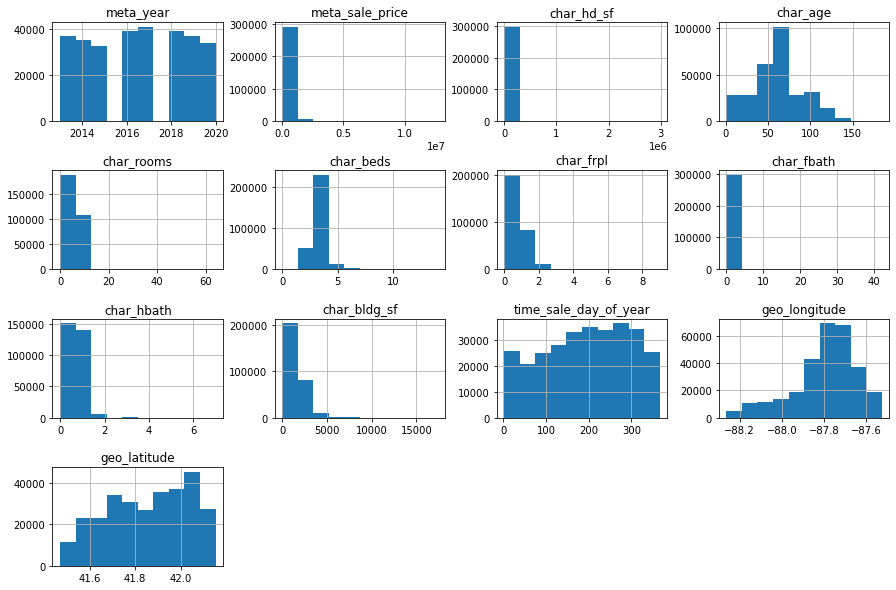

In [26]:
df_bell_sales_mf.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5);

There appear to be gap years in the sales data. There is only slight evidence for a bimodal sales distribution from slight dip less than 1.5 million. But the age is clearly bimodal. There appear to be outliers in hd_sf, rooms, beds, half baths, and bld_sf, 

In [27]:
df_bell_sales_mf.to_csv('../data/bell_sales_cleaned_mhomes.csv')

I have saved single family home data in the Bell district. I have retained numerical features plus class.